# 包

In [2]:
import multiprocessing
from collections import Counter
import xgboost as xgb
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm import tqdm
from sklearn.model_selection import KFold
import gc
from sklearn import preprocessing
from scipy.stats import entropy
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.metrics import roc_auc_score, roc_curve
import datetime
import time
from itertools import product
from itertools import combinations
from sklearn.model_selection import train_test_split, KFold
import missingno as msno
import matplotlib.pyplot as plt
from xgboost.callback import EarlyStopping
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import catboost as cbt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import catboost as cbt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import optuna
import gc
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import catboost as cbt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import optuna
from xgboost.callback import EarlyStopping as XgbEarlyStopping
from lightgbm.callback import early_stopping as lgb_early_stopping
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import catboost as cbt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
import shap 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import catboost as cbt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
import optuna
import gc
import matplotlib.pyplot as plt
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.metrics import roc_auc_score

/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 注意

下方代码块为加载特征工程之后的数据，包括（X_all_train，y_all_train，X_test）。 

如果有数据，可直接跳转至实验部分，如果没有，则按正常流程处理数据即可

In [3]:

save_dir = "./data_processed"

save_dir = "./data_processed"

X_all_train = pd.read_pickle(f"{save_dir}/X_all_train.pkl")
y_all_train = pd.read_pickle(f"{save_dir}/y_all_train.pkl")['isDefault']
X_test = pd.read_pickle(f"{save_dir}/X_test.pkl")

print("读取完成：")
print("X_all_train:", X_all_train.shape)
print("X_test:", X_test.shape)
print("y_all_train:", y_all_train.shape)



读取完成：
X_all_train: (800000, 513)
X_test: (200000, 513)
y_all_train: (800000,)


In [ ]:
# 若无最终submiison_csv的提交需求可不管
test_df = pd.read_csv("./data/testA.csv")
test_ids = test_df['id']

# 数据处理

In [ ]:
def reduce_mem_usage(df):
    """
    遍历 DataFrame 的所有列，修改数据类型以减少内存占用。
    这个版本会特别跳过所有以 'n' 开头的列，让它们保持原始类型。
    """
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    # 定义要跳过的列的特征（n系列）
    n_series_prefix = 'n'
    for col in df.columns:
        # --- 关键修改：在这里加入判断条件 ---
        # 如果列名以 'n' 开头（或者你可以用一个更精确的列表），则跳过这一列
        if col.startswith(n_series_prefix):
            continue # continue 会立即结束本次循环，进入下一列的处理
        col_type = df[col].dtype
        # 对非 object 和非 category 的数值列进行处理
        if col_type != object and not pd.api.types.is_categorical_dtype(df[col]):
            c_min = df[col].min()
            c_max = df[col].max()
            # 整型处理
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            # 浮点型处理
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df





In [ ]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/testA.csv")
# 记录测试集的 ID，以便最后提交
test_ids = test_df['id']
# --- 合并数据 ---
# 在合并前，给 test_df 添加一个 isDefault 列并填充 NaN，作为后续分离的依据
test_df['isDefault'] = np.nan
data = pd.concat([train_df, test_df], ignore_index=True)
print(f"原始训练集形状: {train_df.shape}")
print(f"原始测试集形状: {test_df.shape}")
print(f"合并后数据形状: {data.shape}")
data = reduce_mem_usage(data)

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
print(data.info())

In [ ]:
#采用树模型，因此对数值列填充-999，丢失本身可能也是一种信息
cols_to_fill = ['loanAmnt', 'interestRate', 'installment', 'annualIncome', 'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec', 'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11', 'n12', 'n13', 'n14']
data[cols_to_fill] = data[cols_to_fill].fillna(-999)
# 获取有缺失值的列及其缺失值数量
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0]

# 获取对应列的数据类型
missing_dtypes = data[missing_values.index].dtypes

# 合并缺失值数量和数据类型
missing_info = pd.DataFrame({
    '缺失值数量': missing_values,
    '数据类型': missing_dtypes
})

print('缺失值情况及数据类型：')
print(missing_info)

# n特征处理
n_feat = ['n0', 'n1', 'n2', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11', 'n12', 'n13', 'n14', ]

nameList = ['min', 'max', 'sum', 'mean', 'median', 'skew', 'std', 
            'mode', 'range', 'q25', 'q75']

# statList 中使用 lambda 匿名函数替代自定义函数
statList = [
    'min', 'max', 'sum', 'mean', 'median', 'skew', 'std', 
    lambda x: x.mode().mean() if not x.mode().empty else np.nan, # 众数
    lambda x: x.max() - x.min(),                                 # 值域
    lambda x: x.quantile(0.25),                                  # 25分位数
    lambda x: x.quantile(0.75)                                   # 75分位数
]

# --- 2. 执行聚合 ---
print("\n--- 开始对 n 系列特征进行行聚合统计 (使用 lambda) ---")
for i in tqdm(range(len(nameList)), desc="Aggregating n-features"):
    # 为了避免潜在的 SettingWithCopyWarning，使用 .loc 更安全
    data.loc[:, f'n_feat_{nameList[i]}'] = data[n_feat].agg(statList[i], axis=1)

print(f"n特征聚合处理后，数据形状: {data.shape}")


# 对于等级特征，采用有序编码
data['grade'] = data['grade'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})
data['subGrade'] = data['subGrade'].astype(str)
grade_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
data['subGrade'] = data['subGrade'].str[0].map(grade_map) * 5 + data['subGrade'].str[1].astype(int)

#就业年限处理
if pd.api.types.is_categorical_dtype(data['employmentLength']):
    data['employmentLength'] = data['employmentLength'].astype('object')
data['employmentLength'].fillna(-999, inplace=True)
data.loc[data['employmentLength'] == '< 1 year', 'employmentLength'] = 0.5
data.loc[data['employmentLength'] == '10+ years', 'employmentLength'] = 12
mask = ~data['employmentLength'].isin([-999, 0.5, 12])
data.loc[mask, 'employmentLength'] = data.loc[mask, 'employmentLength'].str.split(' ').str[0].astype(int)
data['employmentLength'] = data['employmentLength'].astype(float)
# unique_values = data['employmentLength'].unique()

# print("'employmentLength' 列中所有不同的数据有:")
#贷款发放日期处理
base_date = pd.to_datetime('2025-01-01')
data['issueDate'] = pd.to_datetime(data['issueDate'])
data = data.assign(
    issueDate_year = data['issueDate'].dt.year,
    issueDate_month = data['issueDate'].dt.month,
    issueDate_day = (base_date - data['issueDate']).dt.days
).assign(
    issueDate_week = lambda df: (df['issueDate_day'] % 7 + 1).astype(int)
)
del data['issueDate']
# 
data['earliesCreditLine_dt'] = pd.to_datetime(data['earliesCreditLine'], format='%b-%Y')
data['credit_history_days'] = (base_date - data['earliesCreditLine_dt']).dt.days
data['credit_history_months'] = (base_date.year - data['earliesCreditLine_dt'].dt.year) * 12 + \
                               (base_date.month - data['earliesCreditLine_dt'].dt.month)
data['earliesCreditLine_year'] = data['earliesCreditLine_dt'].dt.year
data['earliesCreditLine_month'] = data['earliesCreditLine_dt'].dt.month
del data['earliesCreditLine_dt'], data['earliesCreditLine']

print(data[['credit_history_days', 'credit_history_months', 'earliesCreditLine_year', 'earliesCreditLine_month']].head())


# 获取有缺失值的列及其缺失值数量
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0]

# 获取对应列的数据类型
missing_dtypes = data[missing_values.index].dtypes

# 合并缺失值数量和数据类型
missing_info = pd.DataFrame({
    '缺失值数量': missing_values,
    '数据类型': missing_dtypes
})

print('缺失值情况及数据类型：')
print(missing_info)

In [ ]:
data['avg_income'] = data['annualIncome'] / data['employmentLength']
data['total_income'] = data['annualIncome'] * data['employmentLength']
data['avg_loanAmnt'] = data['loanAmnt'] / data['term']
data['mean_interestRate'] = data['interestRate'] / data['term']
data['all_installment'] = data['installment'] * data['term']
data['rest_money_rate'] = data['avg_loanAmnt'] / (data['annualIncome'] + 0.1)  # 287个收入为0
data['rest_money'] = data['annualIncome'] - data['avg_loanAmnt']
data['closeAcc'] = data['totalAcc'] - data['openAcc']
data['ficoRange_mean'] = (data['ficoRangeHigh'] + data['ficoRangeLow']) / 2
data['rest_pubRec'] = data['pubRec'] - data['pubRecBankruptcies']
data['rest_Revol'] = data['loanAmnt'] - data['revolBal']
data['dis_time'] = data['issueDate_year'] - (2020 - data['earliesCreditLine_year'])
for col in ['employmentTitle', 'grade', 'subGrade', 'regionCode', 'issueDate_month', 'postCode']:
    data['{}_count'.format(col)] = data.groupby([col])['id'].transform('count')
# 1. 月度还款占月收入比
data['monthly_debt_to_income'] = data['installment'] / (data['annualIncome'] / 12 + 1e-6)
# 2. 收入扣除分期后剩余 
data['disposable_monthly_income'] = (data['annualIncome'] / 12) - data['installment']
# 3. 贷款总额与年收入比 
data['loan_to_income_ratio'] = data['loanAmnt'] / (data['annualIncome'] + 1e-6)
# 1. 账户开立频率 (平均每个月开立多少个账户)
data['acc_open_frequency'] = data['totalAcc'] / (data['credit_history_months'] + 1e-6)
# 2. 平均每个账户的贷款额
data['avg_loan_per_acc'] = data['loanAmnt'] / (data['totalAcc'] + 1e-6)
# 1. 不良记录密度 (平均每个月有多少不良记录)
data['pubRec_density'] = data['pubRec'] / (data['credit_history_months'] + 1e-6)
# 2. 两年内逾期密度 (平均每个月有多少逾期)
data['delinquency_density_2y'] = data['delinquency_2years'] / 24
# 3. 循环信贷总额度估算
data['estimated_revol_limit'] = data['revolBal'] / (data['revolUtil'] / 100 + 1e-6)
# 4. 未使用的循环信贷额度
data['unused_revol_credit'] = data['estimated_revol_limit'] - data['revolBal']
print('data.shape', data.shape)

In [ ]:
import pandas as pd
from tqdm import tqdm
print("\n--- 开始进行三阶特征交叉 ---")
triple_cross_combinations = [
    # 核心信用等级 + 房屋状况 + 贷款期限
    ['grade', 'homeOwnership', 'term'],
    # 子等级 + 房屋状况 + 贷款期限
    ['subGrade', 'homeOwnership', 'term'],
    # 地理位置 + 等级 + 贷款期限
    ['regionCode', 'grade', 'term'],
    # 贷款用途 + 工作年限 + 房屋状况
    ['purpose', 'employmentLength', 'homeOwnership'],
    # 验证状态 + 贷款用途 + 房屋状况
    ['verificationStatus', 'purpose', 'homeOwnership'],
    # 两个地理位置特征 + 等级
    ['regionCode', 'postCode', 'grade']
]
# --- 2. 循环创建三阶交叉特征 ---
# 确保在运行这段代码前，这些列的缺失值已经被填充 (例如用 'MISSING' 或 -999)
for f_list in tqdm(triple_cross_combinations, desc="Triple Crossing"):
    # 创建新特征的列名，例如 'grade_homeOwnership_term_count'
    feature_name = '_'.join(f_list) + '_count'    
    # 使用 groupby 和 transform('count') 来计算共现次数
    # transform 会返回一个与原始 DataFrame 索引相同的 Series，可以直接赋值
    data[feature_name] = data.groupby(f_list)['id'].transform('count')
    print(f"已创建特征: {feature_name}")
print("\n--- 三阶特征交叉完成 ---")
print(f"处理后数据形状: {data.shape}")
# (可选) 查看新创建的几个特征
new_cols_to_preview = [
    'grade_homeOwnership_term_count',
    'purpose_employmentLength_homeOwnership_count'
]
# 检查列是否存在再打印
cols_to_show = [col for col in new_cols_to_preview if col in data.columns]
if cols_to_show:
    print("\n新创建的三阶交叉特征预览:")
    print(data[cols_to_show].head())

In [ ]:
print("\n--- 开始分离数据 ---")
# 训练集是 isDefault 不为空的行
train_processed = data[data['isDefault'].notna()].copy()
# 测试集是 isDefault 为空的行
test_processed = data[data['isDefault'].isnull()].copy()
# 分离出特征和目标
X_all_train = train_processed.drop(columns=['isDefault'])
y_all_train = train_processed['isDefault']
y_all_train.name = 'isDefault'
# 测试集特征
X_test = test_processed.drop(columns=['isDefault'])
print(f"分离完成: 训练集特征 {X_all_train.shape}, 测试集特征 {X_test.shape}")

In [ ]:
def create_groupby_features(X_train, X_val):
    """
    基于类别特征分组，为数值特征创建更精细的统计特征。(修正版)
    """
    print("\n--- 开始构造精细化的群体统计特征 ---")
    
    cat_cols = ['grade', 'subGrade', 'purpose', 'homeOwnership', 'term', 'employmentLength']
    num_cols = ['annualIncome', 'dti', 'interestRate', 'revolUtil', 'fico_mean', 'loanAmnt']
    
    if 'fico_mean' not in X_train.columns and 'ficoRangeHigh' in X_train.columns:
        X_train['fico_mean'] = (X_train['ficoRangeHigh'] + X_train['ficoRangeLow']) / 2
        X_val['fico_mean'] = (X_val['ficoRangeHigh'] + X_val['ficoRangeLow']) / 2

    X_train_processed = X_train.copy()
    X_val_processed = X_val.copy()
    
    for cat in tqdm(cat_cols, desc="Grouping by Cat Feature"):
        for num in num_cols:
            
            # --- 核心修正：改变 groupby 和 agg 的方式 ---
            
            # a. 定义命名聚合的字典
            #    格式为：新列名 = (要聚合的旧列名, 聚合函数)
            named_agg_dict = {
                f'{cat}_{num}_mean': (num, 'mean'),
                f'{cat}_{num}_std': (num, 'std'),
                f'{cat}_{num}_max': (num, 'max'),
                f'{cat}_{num}_min': (num, 'min'),
                f'{cat}_{num}_median': (num, 'median'),
            }
            
            # b. 在 DataFrameGroupBy 对象上 (X_train_processed.groupby(cat)) 执行命名聚合
            #    注意，我们不再先选择 [num] 列
            agg_map = X_train_processed.groupby(cat).agg(**named_agg_dict)
            
            # c. 将学习到的映射 merge 到训练集和验证集
            X_train_processed = X_train_processed.merge(agg_map, on=cat, how='left')
            X_val_processed = X_val_processed.merge(agg_map, on=cat, how='left')

    # ... 后续的缺失值填充代码不变 ...
    print("\n处理新特征中可能产生的缺失值...")
    fill_value_map = {}
    new_cols = [col for col in X_train_processed.columns if any(stat in col for stat in ['_mean', '_std', '_max', '_min', '_median'])]
    
    for col in new_cols:
        if pd.api.types.is_numeric_dtype(X_train_processed[col]):
            fill_value_map[col] = X_train_processed[col].median()

    X_train_processed.fillna(value=fill_value_map, inplace=True)
    X_val_processed.fillna(value=fill_value_map, inplace=True)
    
    print("--- 精细化群体统计特征构造完成 ---")
    return X_train_processed, X_val_processed

X_all_train,X_test = create_groupby_features(X_all_train, X_test)

In [ ]:
### 用数值特征对类别特征做统计刻画，挑跟isDefalut相关性最高的匿名特征
cross_cat = ['subGrade', 'grade', 'employmentLength', 'term', 'homeOwnership', 'postCode', 'regionCode','employmentTitle','title']
cross_num = ['dti', 'revolBal', 'revolUtil', 'ficoRangeHigh', 'interestRate', 'loanAmnt', 'installment', 'annualIncome', 'n14',
             'n2', 'n3','n1', 'n9', 'n5', 'n7','n10']

for cat in tqdm(cross_cat, desc="Categorical-Numerical Crossing"):
    for num in cross_num:
        feature_name = f'{cat}_{num}_mean'
        mean_map = X_all_train.groupby(cat)[num].mean()
        X_all_train[feature_name] = X_all_train[cat].map(mean_map)
        X_test[feature_name] = X_test[cat].map(mean_map)
        global_num_mean = X_all_train[num].mean()
        X_test[feature_name].fillna(global_num_mean, inplace=True)
        X_all_train[feature_name].fillna(global_num_mean, inplace=True)
print("类别-数值特征交叉完成。") 

for cat1, cat2 in tqdm(list(combinations(cross_cat, 2)), desc="Categorical-Categorical Crossing"):
    feature_name = f'{cat1}_{cat2}_count'

    count_map = X_all_train.groupby([cat1, cat2]).size() 
    count_map.name = feature_name # 给Series命名以便map
    

    train_tuples = list(zip(X_all_train[cat1], X_all_train[cat2]))
    X_all_train[feature_name] = pd.Series(train_tuples).map(count_map)

    val_tuples = list(zip(X_test[cat1], X_test[cat2]))
    X_test[feature_name] = pd.Series(val_tuples).map(count_map)

    X_all_train[feature_name].fillna(0, inplace=True) # 训练集内部也可能有组合未出现（如果map源于子集）
    X_test[feature_name].fillna(0, inplace=True)


print("类别-类别特征交叉完成。")

In [ ]:
for f_pair in tqdm([
    ['subGrade', 'regionCode'], ['grade', 'regionCode'], ['subGrade', 'postCode'], ['grade', 'postCode'], ['employmentTitle','title'],
    ['regionCode','title'], ['postCode','title'], ['homeOwnership','title'], ['homeOwnership','employmentTitle'],['homeOwnership','employmentLength'],
    ['regionCode', 'postCode']
]):
    f1, f2 = f_pair[0], f_pair[1]

    # --- 1. 共现次数 (Co-occurrence Count) ---
    count_feature_name = f'{f1}_{f2}_count'
    # a. 在训练集上学习组合计数的映射
    count_map = X_all_train.groupby([f1, f2]).size()
    # b. 应用到训练集和验证集
    X_all_train[count_feature_name] = pd.MultiIndex.from_frame(X_all_train[[f1, f2]]).map(count_map).fillna(0)
    X_test[count_feature_name] = pd.MultiIndex.from_frame(X_test[[f1, f2]]).map(count_map).fillna(0)

    # --- 2. nunique 和 熵 ---
    # a. f1 -> f2 (e.g., grade -> homeOwnership)
    agg_map = X_all_train.groupby(f1)[f2].agg(['nunique', lambda x: entropy(x.value_counts(normalize=True))])
    agg_map.columns = [f'{f1}_{f2}_nunique', f'{f1}_{f2}_ent']
    X_all_train = X_all_train.merge(agg_map, on=f1, how='left')
    X_test = X_test.merge(agg_map, on=f1, how='left')
    
    # b. f2 -> f1 (e.g., homeOwnership -> grade)
    agg_map = X_all_train.groupby(f2)[f1].agg(['nunique', lambda x: entropy(x.value_counts(normalize=True))])
    agg_map.columns = [f'{f2}_{f1}_nunique', f'{f2}_{f1}_ent']
    X_all_train = X_all_train.merge(agg_map, on=f2, how='left')
    X_test = X_test.merge(agg_map, on=f2, how='left')

    # --- 3. 比例偏好 ---
    # a. 计算单特征计数的映射
    f1_count_map = X_all_train[f1].value_counts()
    f2_count_map = X_all_train[f2].value_counts()
    
    # b. 应用到训练集和验证集，并计算比例
    X_all_train[f1 + '_count'] = X_all_train[f1].map(f1_count_map)
    X_all_train[f2 + '_count'] = X_all_train[f2].map(f2_count_map)
    X_test[f1 + '_count'] = X_test[f1].map(f1_count_map).fillna(0)
    X_test[f2 + '_count'] = X_test[f2].map(f2_count_map).fillna(0)
    
    prop_f1_in_f2_name = f'{f1}_in_{f2}_prop'
    prop_f2_in_f1_name = f'{f2}_in_{f1}_prop'
    
    X_all_train[prop_f1_in_f2_name] = X_all_train[count_feature_name] / (X_all_train[f2 + '_count'] + 1e-6)
    X_all_train[prop_f2_in_f1_name] = X_all_train[count_feature_name] / (X_all_train[f1 + '_count'] + 1e-6)
    X_test[prop_f1_in_f2_name] = X_test[count_feature_name] / (X_test[f2 + '_count'] + 1e-6)
    X_test[prop_f2_in_f1_name] = X_test[count_feature_name] / (X_test[f1 + '_count'] + 1e-6)

    # c. 删除临时的单特征计数列
    X_all_train.drop(columns=[f1 + '_count', f2 + '_count'], inplace=True)
    X_test.drop(columns=[f1 + '_count', f2 + '_count'], inplace=True)

# 必须在分割后进行
for cat in ['grade', 'subGrade', 'purpose']:
    for num in ['annualIncome', 'dti', 'interestRate']:
        # 1. 在 X_all_train 上学习每个类别的均值
        mean_map = X_all_train.groupby(cat)[num].mean()
        
        # 2. 将均值 merge 回 X_all_train 和 X_test
        X_all_train = X_all_train.merge(mean_map.rename(f'{cat}_{num}_group_mean'), on=cat, how='left')
        X_test = X_test.merge(mean_map.rename(f'{cat}_{num}_group_mean'), on=cat, how='left')
        
        # 3. 构造差异特征
        X_all_train[f'{num}_minus_{cat}_mean'] = X_all_train[num] - X_all_train[f'{cat}_{num}_group_mean']
        X_test[f'{num}_minus_{cat}_mean'] = X_test[num] - X_test[f'{cat}_{num}_group_mean']
        
        # 4. 构造比率特征
        X_all_train[f'{num}_ratio_{cat}_mean'] = X_all_train[num] / (X_all_train[f'{cat}_{num}_group_mean'] + 1e-6)
        X_test[f'{num}_ratio_{cat}_mean'] = X_test[num] / (X_test[f'{cat}_{num}_group_mean'] + 1e-6)

        # 5. 清理临时的均值列
        X_all_train.drop(columns=[f'{cat}_{num}_group_mean'], inplace=True)
        X_test.drop(columns=[f'{cat}_{num}_group_mean'], inplace=True)
        
        # 6. 别忘了填充 X_test 中可能产生的 NaN


In [ ]:
target_encode_cols = [
    'homeOwnership', 'verificationStatus', 'purpose', 'initialListStatus', 
    'applicationType', 'postCode', 'regionCode', 'employmentTitle', 'title'
]

print("检查并填充目标编码列的缺失值...")
for col in target_encode_cols:
    if X_all_train[col].isnull().any():
        X_all_train[col].fillna('MISSING', inplace=True)
    if X_test[col].isnull().any():
        X_test[col].fillna('MISSING', inplace=True)

kfold_num = 5
skf = KFold(n_splits=kfold_num, shuffle=True, random_state=42)
global_mean = y_all_train.mean()

print("在 X_all_train 上执行 K-Fold 目标编码...")

new_feature_names = []

for f in tqdm(target_encode_cols, desc="Encoding Training Set"):
    
    new_col_name = f'{f}_target_mean'
    X_all_train[new_col_name] = 0
    new_feature_names.append(new_col_name)

    # K-Fold 交叉验证循环
    for i, (trn_idx, val_idx) in enumerate(skf.split(X_all_train, y_all_train)):
        # 将训练集再次分割成 K-1 折的 "学习集" 和 1 折的 "应用集"
        trn_x, val_x = X_all_train.iloc[trn_idx], X_all_train.iloc[val_idx]
        trn_y = y_all_train.iloc[trn_idx]
        
        # 在 K-1 折上计算每个类别的目标均值
        target_mean_map = trn_y.groupby(trn_x[f]).mean()
        
        # 将计算出的均值应用到 1 折的 "应用集" 上
        true_val_indices = val_x.index 
        X_all_train.loc[true_val_indices, new_col_name] = val_x[f].map(target_mean_map)

    # 填充在 K-Fold 过程中可能产生的 NaN
    X_all_train[new_col_name].fillna(global_mean, inplace=True)
    

print("\n使用在 X_all_train 上学习的规则转换 X_test...")

for f in tqdm(target_encode_cols, desc="Transforming Validation Set"):
    new_col_name = f'{f}_target_mean'
    
    # 计算在整个 X_all_train 上的目标均值映射
    overall_mean_map = y_all_train.groupby(X_all_train[f]).mean()
    # 将这个规则应用到 X_test 上
    X_test[new_col_name] = X_test[f].map(overall_mean_map)
    # 填充 X_test 中可能产生的 NaN
    X_test[new_col_name].fillna(global_mean, inplace=True)

print("\n目标编码完成！")

print("删除原始类别列...")
X_all_train.drop(columns=target_encode_cols, inplace=True)
X_test.drop(columns=target_encode_cols, inplace=True)

print("\n--- 最终结果预览 ---")
print("处理后的训练集形状:", X_all_train.shape)
print("处理后的验证集形状:", X_test.shape)
print("\n训练集中新创建的特征:")
print(X_all_train[new_feature_names].head())
print("\n验证集中新创建的特征:")
print(X_test[new_feature_names].head())

In [ ]:
fill_value_map = {}
for col in tqdm(X_all_train.columns, desc="Learning Fill Values"):
    # 我们只对数值类型的列计算中位数作为填充值
    # 如果列是 object 类型（例如原始的类别列还没删），则不处理
    if pd.api.types.is_numeric_dtype(X_all_train[col]):
        fill_value_map[col] = X_all_train[col].median()

# 3. 使用学习到的规则（fill_value_map）来统一填充训练集和验证集
print("应用填充规则到 X_all_train 和 X_test...")
X_all_train.fillna(value=fill_value_map, inplace=True)
X_test.fillna(value=fill_value_map, inplace=True)


# --- 最终检查 ---
print("\n--- 再次检查最终的缺失值情况 ---")
train_missing_count = X_all_train.isnull().sum().sum()
val_missing_count = X_test.isnull().sum().sum()

print(f"填充后，X_train 中总缺失值数量: {train_missing_count}")
print(f"填充后，X_val 中总缺失值数量: {val_missing_count}")

if train_missing_count == 0 and val_missing_count == 0:
    print("\n太棒了！所有缺失值都已成功处理完毕！")
else:
    print("\n警告！仍然存在缺失值，请检查流程。")

In [ ]:
print("--- 检查最终 X_all_train 的缺失值情况 ---")
missing_values_train = X_all_train.isnull().sum()
missing_values_train = missing_values_train[missing_values_train > 0]

if not missing_values_train.empty:
    missing_dtypes_train = X_all_train[missing_values_train.index].dtypes
    missing_info_train = pd.DataFrame({
        '缺失值数量': missing_values_train,
        '数据类型': missing_dtypes_train
    })
    print('X_all_train 中的缺失值情况及数据类型：')
    print(missing_info_train)
else:
    print("X_all_train 中没有缺失值。")


# --- 检查 X_test 的缺失值情况 ---
print("\n--- 检查最终 X_test 的缺失值情况 ---")
missing_values_val = X_test.isnull().sum()
missing_values_val = missing_values_val[missing_values_val > 0]

if not missing_values_val.empty:
    missing_dtypes_val = X_test[missing_values_val.index].dtypes
    missing_info_val = pd.DataFrame({
        '缺失值数量': missing_values_val,
        '数据类型': missing_dtypes_val
    })
    print('X_test 中的缺失值情况及数据类型：')
    print(missing_info_val)
else:
    print("X_test 中没有缺失值。")

# 实验部分

In [4]:
print(f"训练集: {X_all_train.shape}, 验证集: {X_test.shape}")
X_all_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_all_train.columns]
X_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_test.columns]

训练集: (800000, 513), 验证集: (200000, 513)


--- 第一部分：通过交叉验证获取特征重要性 ---
正在训练第 1/5 折...


/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:01:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:02:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


正在训练第 2/5 折...


/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:02:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:02:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


正在训练第 3/5 折...


/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:02:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:03:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


正在训练第 4/5 折...


/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:03:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:03:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


正在训练第 5/5 折...


/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:03:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:03:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


已生成 429 个特征的平均重要性排序。

--- 第二部分：通过交叉验证测试不同数量的特征子集 ---


Testing Feature Subsets:   0%|          | 0/15 [00:00<?, ?it/s]/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:04:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:04:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:

使用 50 个特征, 平均 CV AUC: 0.72616


/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:04:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:04:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:04:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgbo

使用 80 个特征, 平均 CV AUC: 0.73632


/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:04:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:05:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:05:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgbo

使用 100 个特征, 平均 CV AUC: 0.73833


/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:05:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:05:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:05:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgbo

使用 120 个特征, 平均 CV AUC: 0.74017


/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:06:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:06:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:06:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgbo

使用 150 个特征, 平均 CV AUC: 0.74090


/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:07:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:07:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:07:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgbo

使用 200 个特征, 平均 CV AUC: 0.74132


/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:08:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:08:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:08:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgbo

使用 230 个特征, 平均 CV AUC: 0.74154


/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:09:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:09:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:09:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgbo

使用 250 个特征, 平均 CV AUC: 0.74149


/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:10:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:10:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:10:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgbo

使用 280 个特征, 平均 CV AUC: 0.74174


/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:11:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:11:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:11:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgbo

使用 300 个特征, 平均 CV AUC: 0.74142


/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:12:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:12:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:12:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgbo

使用 320 个特征, 平均 CV AUC: 0.74131


/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:13:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:14:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:14:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgbo

使用 340 个特征, 平均 CV AUC: 0.74138


/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:15:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:15:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:15:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgbo

使用 360 个特征, 平均 CV AUC: 0.74140


/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:16:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:16:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:17:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgbo

使用 380 个特征, 平均 CV AUC: 0.74119


/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:18:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:18:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:18:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgbo

使用 400 个特征, 平均 CV AUC: 0.74119

--- 第三部分：分析实验结果 ---
不同特征数量下的 AUC 分数:
50     0.726162
80     0.736316
100    0.738331
120    0.740175
150    0.740901
200    0.741317
230    0.741536
250    0.741493
280    0.741736
300    0.741416
320    0.741313
340    0.741380
360    0.741403
380    0.741192
400    0.741189
dtype: float64

最佳性能点: 使用 280 个特征时，AUC 达到最高值 0.74174
推荐的“性价比”点: 使用 200 个特征时，性能已达到最佳的99.9%以上。


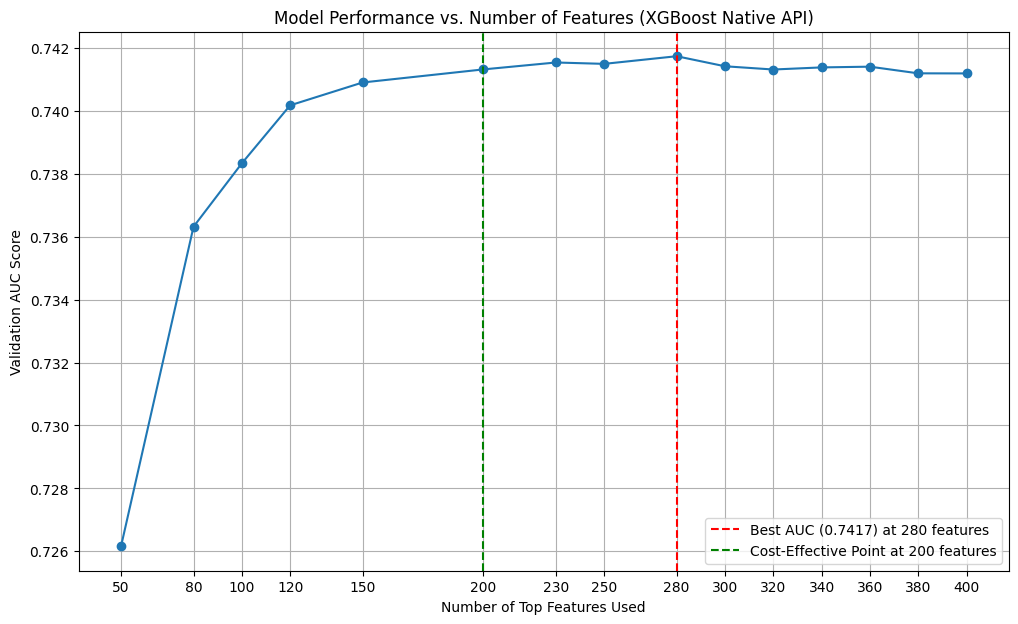


最终决定使用 200 个特征。
最终训练集形状: (800000, 200)
最终验证集形状: (200000, 200)


In [5]:



# ==============================================================================
# 第一部分：通过交叉验证，获取稳健的特征重要性排序
# ==============================================================================
print("--- 第一部分：通过交叉验证获取特征重要性 ---")

# 1. 定义参数和 K-Fold
params_for_sorting = {
    'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc',
    'min_child_weight': 5, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.6,
    'eta': 0.05, 'seed': 42, 'nthread': -1, 'tree_method': 'gpu_hist'
}
k = 5
folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# 2. 创建一个 DataFrame 来存储每一折的重要性
feature_importance_df = pd.DataFrame()

# 3. K-Fold 循环
for i, (train_index, val_index) in enumerate(folds.split(X_all_train, y_all_train)):
    print(f"正在训练第 {i+1}/{k} 折...")
    # 分割数据
    train_X, val_X = X_all_train.iloc[train_index], X_all_train.iloc[val_index]
    train_y, val_y = y_all_train.iloc[train_index], y_all_train.iloc[val_index]
    
    # 创建 DMatrix
    dtrain = xgb.DMatrix(train_X, label=train_y)
    dval = xgb.DMatrix(val_X, label=val_y)
    watchlist = [(dtrain, 'train'), (dval, 'eval')]
    
    # 训练模型
    model = xgb.train(
        params_for_sorting, dtrain, num_boost_round=1000, 
        evals=watchlist, verbose_eval=False, early_stopping_rounds=100
    )
    
    # 收集重要性
    fold_importance = pd.Series(model.get_score(importance_type='gain'), name=f'fold_{i+1}')
    feature_importance_df = pd.concat([feature_importance_df, fold_importance], axis=1)

# 4. 计算平均重要性并排序
feature_importance_df.fillna(0, inplace=True)
feature_importance_df['mean'] = feature_importance_df.mean(axis=1)
sorted_features = feature_importance_df.sort_values(by='mean', ascending=False).index.tolist()

print(f"已生成 {len(sorted_features)} 个特征的平均重要性排序。")


# ==============================================================================
# 第二部分：通过交叉验证，循环测试不同的特征数量
# ==============================================================================
print("\n--- 第二部分：通过交叉验证测试不同数量的特征子集 ---")

n_features_to_test = [50, 80, 100, 120, 150, 200,230,250,280,300,320,340,360,380,400]
results = {}
params_for_testing = params_for_sorting.copy()

for n in tqdm(n_features_to_test, desc="Testing Feature Subsets"):
    top_n_features = sorted_features[:n]
    
    fold_scores = []
    # 同样使用 K-Fold 来评估，保证评估的可靠性
    for i, (train_index, val_index) in enumerate(folds.split(X_all_train, y_all_train)):
        train_X, val_X = X_all_train[top_n_features].iloc[train_index], X_all_train[top_n_features].iloc[val_index]
        train_y, val_y = y_all_train.iloc[train_index], y_all_train.iloc[val_index]

        dtrain_subset = xgb.DMatrix(train_X, label=train_y)
        dval_subset = xgb.DMatrix(val_X, label=val_y)
        watchlist_subset = [(dtrain_subset, 'train'), (dval_subset, 'eval')]
        
        model = xgb.train(params_for_testing, dtrain_subset, num_boost_round=1000,
                          evals=watchlist_subset, verbose_eval=False, early_stopping_rounds=50)
        
        y_pred_proba = model.predict(dval_subset, iteration_range=(0, model.best_iteration))
        fold_scores.append(roc_auc_score(val_y, y_pred_proba))
        
    results[n] = np.mean(fold_scores)
    print(f"使用 {n} 个特征, 平均 CV AUC: {results[n]:.5f}")
# ==============================================================================
# 第三部分：分析并可视化结果 (这部分代码和之前一样)
# ==============================================================================

print("\n--- 第三部分：分析实验结果 ---")

results_series = pd.Series(results)
print("不同特征数量下的 AUC 分数:")
print(results_series)

best_n = results_series.idxmax()
best_auc = results_series.max()
print(f"\n最佳性能点: 使用 {best_n} 个特征时，AUC 达到最高值 {best_auc:.5f}")

performance_threshold = best_auc * 0.999
cost_effective_n = results_series[results_series >= performance_threshold].index[0]
print(f"推荐的“性价比”点: 使用 {cost_effective_n} 个特征时，性能已达到最佳的99.9%以上。")

plt.figure(figsize=(12, 7))
results_series.plot(kind='line', marker='o', grid=True)
plt.axvline(x=best_n, color='r', linestyle='--', label=f'Best AUC ({best_auc:.4f}) at {best_n} features')
plt.axvline(x=cost_effective_n, color='g', linestyle='--', label=f'Cost-Effective Point at {cost_effective_n} features')
plt.title('Model Performance vs. Number of Features (XGBoost Native API)')
plt.xlabel('Number of Top Features Used')
plt.ylabel('Validation AUC Score')
plt.xticks(n_features_to_test)
plt.legend()
plt.show()

# --- 最终决策 ---
FINAL_FEATURE_COUNT = cost_effective_n
final_features_list = sorted_features[:FINAL_FEATURE_COUNT]

X_train_final = X_all_train[final_features_list]
X_val_final = X_test[final_features_list]

print(f"\n最终决定使用 {FINAL_FEATURE_COUNT} 个特征。")
print(f"最终训练集形状: {X_train_final.shape}")
print(f"最终验证集形状: {X_val_final.shape}")

In [6]:
FINAL_FEATURE_COUNT = 340
final_features_list = sorted_features[:FINAL_FEATURE_COUNT]


X_train_final = X_all_train[final_features_list]
X_val_final = X_test[final_features_list]
y_all_train

0         1.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
799995    0.0
799996    0.0
799997    1.0
799998    0.0
799999    0.0
Name: isDefault, Length: 800000, dtype: float32

In [7]:
print(f"\n最终决定使用 {FINAL_FEATURE_COUNT} 个特征。")
print(f"最终训练集形状: {X_train_final.shape}")
print(f"最终验证集形状: {X_val_final.shape}")


最终决定使用 340 个特征。
最终训练集形状: (800000, 340)
最终验证集形状: (200000, 340)



## 超参数搜索


**关于最优超参数搜索模块，如果前面没有改变模型，则不必要重新搜索，后面已经保存了之前搜索过的最优超参数**

In [ ]:

# # ==============================================================================
# # 0. 准备工作：降低数据精度
# # ==============================================================================
# # 假设此时你已经有了处理好的 X_all_train, y_all_train
# print("--- 步骤 0: 降低数据精度 (float64 -> float32) ---")

# def downcast_floats(df):
#     float_cols = df.select_dtypes(include=['float64']).columns
#     for col in float_cols:
#         df[col] = pd.to_numeric(df[col], downcast='float')
#     return df

# X_all_train = downcast_floats(X_all_train)
# print("数据精度已优化。")


# # ==============================================================================
# # 1. 修改目标函数：内部进行临时分割和垃圾回收
# # ==============================================================================

# def objective_xgb_final_mem_opt(trial, X_all, y_all):
#     """XGBoost 的目标函数 (最终预测阶段的内存优化版)"""
#     X_t, X_v, y_t, y_v = train_test_split(X_all, y_all, test_size=0.1, random_state=trial.number, stratify=y_all)
#     params = {
#         'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree',
#         'tree_method': 'gpu_hist', 'random_state': 42,
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#     }
#     dtrain = xgb.DMatrix(X_t, label=y_t)
#     dval = xgb.DMatrix(X_v, label=y_v)
#     pruning_callback = optuna.integration.XGBoostPruningCallback(trial, 'validation-auc')
#     model = xgb.train(params, dtrain, num_boost_round=1000,
#                       evals=[(dval, 'validation')],
#                       callbacks=[pruning_callback, xgb.callback.EarlyStopping(100)],
#                       verbose_eval=False)
#     auc = model.best_score
#     del model, dtrain, dval, X_t, X_v, y_t, y_v; gc.collect()
#     return auc

# def objective_lgb_final_mem_opt(trial, X_all, y_all):
#     """LightGBM 的目标函数 (最终预测阶段的内存优化版)"""
#     X_t, X_v, y_t, y_v = train_test_split(X_all, y_all, test_size=0.1, random_state=trial.number, stratify=y_all)
#     params = {
#         'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt',
#         'device': 'gpu', 'random_state': 42, 'n_jobs': -1, 'verbose': -1,
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
#         'num_leaves': trial.suggest_int('num_leaves', 20, 300),
#     }
#     dtrain = lgb.Dataset(X_t, label=y_t)
#     dval = lgb.Dataset(X_v, label=y_v)
#     pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'auc', 'valid_0')
#     model = lgb.train(params, dtrain, num_boost_round=1000, valid_sets=[dval],
#                       callbacks=[pruning_callback, lgb.early_stopping(100, verbose=False)])
#     auc = model.best_score['valid_0']['auc']
#     del model, dtrain, dval, X_t, X_v, y_t, y_v; gc.collect()
#     return auc

# def objective_cat_final_mem_opt(trial, X_all, y_all):
#     """CatBoost 的目标函数 (最终预测阶段的内存优化版)"""
#     X_t, X_v, y_t, y_v = train_test_split(X_all, y_all, test_size=0.1, random_state=trial.number, stratify=y_all)
#     params = {
#         'objective': 'Logloss', 'eval_metric': 'AUC', 'task_type': 'GPU',
#         'random_seed': 42, 'verbose': 0,
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
#         'depth': trial.suggest_int('depth', 4, 10),
#         'iterations': 1000, 'early_stopping_rounds': 100
#     }
#     model = cbt.CatBoostClassifier(**params)
#     model.fit(X_t, y_t, eval_set=[(X_v, y_v)], use_best_model=True)
#     auc = model.get_best_score()['validation']['AUC']
#     del model, X_t, X_v, y_t, y_v; gc.collect()
#     return auc

# # ==============================================================================
# # 2. 运行统一的调优框架
# # ==============================================================================
# models_to_tune_final = {
#     'xgboost': objective_xgb_final_mem_opt,
#     'lightgbm': objective_lgb_final_mem_opt,
#     'catboost': objective_cat_final_mem_opt
# }

# best_params_all_final = {}
# best_scores_all_final = {}

# for model_name, objective_func in models_to_tune_final.items():
#     print(f"\n--- 在全部数据上为 {model_name.upper()} 搜索超参数 (内存优化版) ---")
#     study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
#     try:
#         # 使用 lambda 将 X_all_train 和 y_all_train 传入
#         study.optimize(lambda trial: objective_func(trial, X_all_train, y_all_train), n_trials=50, gc_after_trial=True)
#         best_params_all_final[model_name] = study.best_trial.params
#         best_scores_all_final[model_name] = study.best_trial.value
#         print(f"--- {model_name.upper()} 调优完成 ---")
#         print(f"最佳 Validation AUC: {best_scores_all_final[model_name]:.6f}")
#         print("最佳超参数组合:")
#         print(best_params_all_final[model_name])
#         # ... (打印结果的代码不变) ...
#     except Exception as e:
#         print(f"!!! {model_name.upper()} 调优过程中出现错误: {e}")
#         continue

In [8]:
print("--- 根据已有的日志和 objective 函数定义，手动重建最佳参数和分数 ---")

# --- 1. 创建 best_params_all 字典 ---
best_params_all = {
    'xgboost': {
        # 根据你的 objective_xgb_final_mem_opt 函数：
        'learning_rate': 0.03945974879663297, 
        'max_depth': 8, 
        'subsample': 0.6871107520310088, 
        'colsample_bytree': 0.8936194372129961
        # 注意：你最新提供的 objective_xgb 函数里没有 subsample 和 colsample_bytree。
        # 但你的日志里有。我假设日志是正确的，这里保留它们。
        # 如果你确定最终版本没调这两个参数，可以把它们删掉。
    },
    'lightgbm': {
        # 根据你的 objective_lgb_final_mem_opt 函数：
        'learning_rate': 0.04717797461729656, 
        'num_leaves': 68
        # 这个是完全匹配的，只调了这两个参数。
    },
    'catboost': {
        # 根据你的 objective_cat_final_mem_opt 函数：
        'learning_rate': 0.06067269115304827, 
        'depth': 7
        # 这个也是完全匹配的，只调了这两个参数。
    }
}



# --- 2. 创建 best_scores_all 字典 ---
best_scores_all = {
    'xgboost': 0.7456015793129649,
    'lightgbm': 0.7447491241443516,
    'catboost': 0.7455698251724243
}

print("\n--- 手动创建的最佳参数和分数字典 ---")

print("\n--- best_params_all ---")
print(best_params_all)

print("\n--- best_scores_all ---")
print(best_scores_all)

# --- 格式化打印 ---
print("\n\n--- 格式化结果预览 ---")
for model_name in best_params_all.keys():
    print(f"\n--- {model_name.upper()} ---")
    print(f"最佳 AUC: {best_scores_all.get(model_name, 'N/A'):.6f}")
    print(f"最佳参数: {best_params_all.get(model_name, 'N/A')}")

--- 根据已有的日志和 objective 函数定义，手动重建最佳参数和分数 ---

--- 手动创建的最佳参数和分数字典 ---

--- best_params_all ---
{'xgboost': {'learning_rate': 0.03945974879663297, 'max_depth': 8, 'subsample': 0.6871107520310088, 'colsample_bytree': 0.8936194372129961}, 'lightgbm': {'learning_rate': 0.04717797461729656, 'num_leaves': 68}, 'catboost': {'learning_rate': 0.06067269115304827, 'depth': 7}}

--- best_scores_all ---
{'xgboost': 0.7456015793129649, 'lightgbm': 0.7447491241443516, 'catboost': 0.7455698251724243}


--- 格式化结果预览 ---

--- XGBOOST ---
最佳 AUC: 0.745602
最佳参数: {'learning_rate': 0.03945974879663297, 'max_depth': 8, 'subsample': 0.6871107520310088, 'colsample_bytree': 0.8936194372129961}

--- LIGHTGBM ---
最佳 AUC: 0.744749
最佳参数: {'learning_rate': 0.04717797461729656, 'num_leaves': 68}

--- CATBOOST ---
最佳 AUC: 0.745570
最佳参数: {'learning_rate': 0.06067269115304827, 'depth': 7}


In [9]:

best_params_all_final = best_params_all

# --- XGBoost 最终训练函数 ---
def train_final_xgb(X_train, y_train, X_val, params, k=5, seeds=[42]):
    oof_preds = np.zeros(X_train.shape[0])
    val_preds_ensembled = np.zeros(X_val.shape[0])
    
    for seed in tqdm(seeds, desc="XGB Seed Loop"):
        params['seed'] = seed
        folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
        for i, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
            trn_X, val_X = X_train.iloc[trn_idx], X_train.iloc[val_idx]
            trn_y, val_y = y_train.iloc[trn_idx], y_train.iloc[val_idx]
            
            dtrain = xgb.DMatrix(trn_X, label=trn_y)
            dval = xgb.DMatrix(val_X, label=val_y)
            dtest = xgb.DMatrix(X_val)
            
            model = xgb.train(params, dtrain, num_boost_round=10000, evals=[(dval, 'v')], 
                              verbose_eval=False, early_stopping_rounds=600)
            
            oof_preds[val_idx] += model.predict(dval, iteration_range=(0, model.best_iteration)) / len(seeds)
            val_preds_ensembled += model.predict(dtest, iteration_range=(0, model.best_iteration)) / (k * len(seeds))
            
    return oof_preds, val_preds_ensembled

# --- LightGBM 最终训练函数 ---
def train_final_lgb(X_train, y_train, X_val, params, k=5, seeds=[42]):
    oof_preds = np.zeros(X_train.shape[0])
    val_preds_ensembled = np.zeros(X_val.shape[0])
    
    for seed in tqdm(seeds, desc="LGB Seed Loop"):
        params['random_state'] = seed
        folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
        for i, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
            trn_X, val_X = X_train.iloc[trn_idx], X_train.iloc[val_idx]
            trn_y, val_y = y_train.iloc[trn_idx], y_train.iloc[val_idx]
            
            dtrain = lgb.Dataset(trn_X, label=trn_y)
            dval = lgb.Dataset(val_X, label=val_y)
            
            model = lgb.train(params, dtrain, num_boost_round=10000, valid_sets=[dval],
                              callbacks=[lgb.early_stopping(100, verbose=False)])
            
            oof_preds[val_idx] += model.predict(val_X, num_iteration=model.best_iteration) / len(seeds)
            val_preds_ensembled += model.predict(X_val, num_iteration=model.best_iteration) / (k * len(seeds))
            
    return oof_preds, val_preds_ensembled

# --- CatBoost 最终训练函数 ---
def train_final_cat(X_train, y_train, X_val, params, k=5, seeds=[42]):
    oof_preds = np.zeros(X_train.shape[0])
    val_preds_ensembled = np.zeros(X_val.shape[0])
    
    for seed in tqdm(seeds, desc="CAT Seed Loop"):
        params['random_seed'] = seed
        folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
        for i, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
            trn_X, val_X = X_train.iloc[trn_idx], X_train.iloc[val_idx]
            trn_y, val_y = y_train.iloc[trn_idx], y_train.iloc[val_idx]
            
            model = cbt.CatBoostClassifier(**params)
            model.fit(trn_X, trn_y, eval_set=[(val_X, val_y)], use_best_model=True)
            
            oof_preds[val_idx] += model.predict_proba(val_X)[:, 1] / len(seeds)
            val_preds_ensembled += model.predict_proba(X_val)[:, 1] / (k * len(seeds))
            
    return oof_preds, val_preds_ensembled

params_xgb = best_params_all_final['xgboost'].copy()
params_xgb.update({'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist'})



params_lgb = best_params_all_final['lightgbm'].copy()

params_lgb.update({
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'device_type': 'cpu',   
    'n_jobs': -1,
    'verbose': -1,
})

# params_lgb = best_params_all_final['lightgbm']
# params_lgb.update({'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'n_jobs': -1, 'verbose': -1})

params_cat = best_params_all_final['catboost']
params_cat.update({'objective': 'Logloss', 'eval_metric': 'AUC', 'task_type': 'GPU', 'verbose': 0, 'iterations': 10000, 'early_stopping_rounds': 600})

# 定义种子和折数
k = 5
seeds = [20041110, 20050327, 20050217]

# 分别运行每个模型的训练
oof_lgb, preds_lgb = train_final_lgb(X_train_final, y_all_train, X_val_final, params_lgb, k, seeds)
oof_xgb, preds_xgb = train_final_xgb(X_train_final, y_all_train, X_val_final, params_xgb, k, seeds)
oof_cat, preds_cat = train_final_cat(X_train_final, y_all_train, X_val_final, params_cat, k, seeds)



print("\n" + "="*50)
print("--- 模型融合与提交文件生成 ---")
print("="*50)

# --- a. Stacking 融合 ---
print("\n--- 使用 Stacking 融合模型 ---")

# 1. 创建第二层训练数据 (只使用 OOF 预测)
X_train_layer2 = pd.DataFrame({
    'xgb': oof_xgb,
    'lgb': oof_lgb,
    'cat': oof_cat
})

# 2. 创建第二层测试数据 (使用对测试集的预测)
X_test_layer2 = pd.DataFrame({
    'xgb': preds_xgb,
    'lgb': preds_lgb,
    'cat': preds_cat
})

# 3. (新增) 使用 LogisticRegressionCV 调优元模型参数 C
print("正在为元模型(逻辑回归)进行交叉验证以寻找最佳 C 值...")

# Cs=20: 尝试20个候选的C值
# cv=5: 使用5折交叉验证
# scoring='roc_auc': 优化的目标是最大化AUC
# n_jobs=-1: 使用所有CPU核心
# random_state: 保证结果可复现
meta_model_cv = LogisticRegressionCV(
    Cs=20, 
    cv=5, 
    scoring='roc_auc', 
    random_state=42, 
    n_jobs=-1,
    max_iter=1000 # 增加最大迭代次数以确保收敛
)
meta_model_cv.fit(X_train_layer2, y_all_train)

# 获取找到的最佳 C 值
best_c = meta_model_cv.C_[0]
print(f"元模型找到的最佳 C 值是: {best_c:.6f}")


# 4. 使用找到的最佳 C 值，在全部 OOF 数据上训练最终的元模型
print("使用最佳 C 值训练最终元模型...")
final_meta_model = LogisticRegression(C=best_c, random_state=42, max_iter=1000)
final_meta_model.fit(X_train_layer2, y_all_train)
print("元模型训练完成。")

# 打印元模型学习到的权重 (系数)
print("元模型学习到的权重 (系数):")
print(pd.Series(final_meta_model.coef_[0], index=X_test_layer2.columns))


# 5. 对测试集进行最终预测
final_predictions_stacking = final_meta_model.predict_proba(X_test_layer2)[:, 1]
print("已生成对测试集的最终 Stacking 预测。")


XGB Seed Loop:   0%|          | 0/3 [00:00<?, ?it/s]/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:36:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:37:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397688861/work/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/qyx/anaconda3/envs/TGP3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:37:06] WARN


--- 模型融合与提交文件生成 ---

--- 使用 Stacking 融合模型 ---
正在为元模型(逻辑回归)进行交叉验证以寻找最佳 C 值...


元模型找到的最佳 C 值是: 0.233572
使用最佳 C 值训练最终元模型...
元模型训练完成。
元模型学习到的权重 (系数):
xgb    2.003810
lgb    1.927735
cat    1.997934
dtype: float64
已生成对测试集的最终 Stacking 预测。


In [ ]:
# --- b. 生成提交文件 ---
# Stacking 结果
submission_stacking = pd.DataFrame({
    'id': test_ids,
    'isDefault': final_predictions_stacking
})
submission_path_stacking = 'submission_stacking_tuned.csv'
submission_stacking.to_csv(submission_path_stacking, index=False)
print(f"\n已生成调优后的 Stacking 提交文件: '{submission_path_stacking}'")
print(submission_stacking.head())

In [ ]:
print("  SHAP 特征贡献分析")

# ------------------------------
# 工具函数：根据模型返回正确列的 shap values
# ------------------------------
def _normalize_shap_values(shap_values):
    if isinstance(shap_values, list):
        # 二分类模型：取正类那一列
        return shap_values[1]
    else:
        return shap_values

# ------------------------------
# 1) LightGBM SHAP
# ------------------------------
print("\n>>> LightGBM SHAP 分析开始（强制 CPU 避免 OpenCL 错误）")

params_lgb_shap = params_lgb.copy()
# 避免 OpenCL 报错，强制 CPU
params_lgb_shap.pop("device", None)
params_lgb_shap["device_type"] = "cpu"

# 划分数据
X_tr_lgb, X_val_lgb, y_tr_lgb, y_val_lgb = train_test_split(
    X_train_final, y_all_train, test_size=0.2, random_state=2025, stratify=y_all_train
)

dtrain_lgb = lgb.Dataset(X_tr_lgb, label=y_tr_lgb)
dval_lgb = lgb.Dataset(X_val_lgb, label=y_val_lgb)

lgb_shap_model = lgb.train(
    params_lgb_shap,
    dtrain_lgb,
    num_boost_round=10000,
    valid_sets=[dval_lgb],
    callbacks=[lgb.early_stopping(100, verbose=False)]
)

explainer_lgb = shap.TreeExplainer(lgb_shap_model)
shap_values_lgb = explainer_lgb.shap_values(X_val_lgb)
shap_values_lgb = _normalize_shap_values(shap_values_lgb)

print("绘制 LightGBM SHAP summary...")
shap.summary_plot(shap_values_lgb, X_val_lgb, max_display=30, show=True)


# ------------------------------
# 2) XGBoost SHAP
# ------------------------------
print("\n>>> XGBoost SHAP 分析开始")

# 划分数据
X_tr_xgb, X_val_xgb, y_tr_xgb, y_val_xgb = train_test_split(
    X_train_final, y_all_train, test_size=0.2, random_state=2025, stratify=y_all_train
)

dtrain_xgb = xgb.DMatrix(X_tr_xgb, label=y_tr_xgb)
dval_xgb = xgb.DMatrix(X_val_xgb, label=y_val_xgb)

params_xgb_shap = params_xgb.copy()
# 如果 GPU 不可用，可以改为 hist:
# params_xgb_shap["tree_method"] = "hist"

xgb_shap_model = xgb.train(
    params_xgb_shap,
    dtrain_xgb,
    num_boost_round=10000,
    evals=[(dval_xgb, "valid")],
    early_stopping_rounds=100,
    verbose_eval=False
)

explainer_xgb = shap.TreeExplainer(xgb_shap_model)
shap_values_xgb = explainer_xgb.shap_values(X_val_xgb)

print("绘制 XGBoost SHAP summary...")
shap.summary_plot(shap_values_xgb, X_val_xgb, max_display=30, show=True)


# ------------------------------
# 3) CatBoost SHAP
# ------------------------------
print("\n>>> CatBoost SHAP 分析开始")

# 划分数据
X_tr_cat, X_val_cat, y_tr_cat, y_val_cat = train_test_split(
    X_train_final, y_all_train, test_size=0.2, random_state=2025, stratify=y_all_train
)

params_cat_shap = params_cat.copy()
# GPU 可用继续 GPU，否则强制 CPU：
# params_cat_shap["task_type"] = "CPU"

cat_shap_model = cbt.CatBoostClassifier(**params_cat_shap)
cat_shap_model.fit(
    X_tr_cat, y_tr_cat,
    eval_set=(X_val_cat, y_val_cat),
    use_best_model=True,
    verbose=False
)

explainer_cat = shap.TreeExplainer(cat_shap_model)
shap_values_cat = explainer_cat.shap_values(X_val_cat)
shap_values_cat = _normalize_shap_values(shap_values_cat)

print("绘制 CatBoost SHAP summary...")
shap.summary_plot(shap_values_cat, X_val_cat, max_display=30, show=True)


print("\n==============================")
print("         SHAP 分析完成")
print("==============================\n")


# 模型平行对比

In [ ]:

def train_final_lr(X_train, y_train, k=5, seeds=[42]):
    oof_preds = np.zeros(X_train.shape[0])
    auc_scores = []

    for seed in seeds:
        folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
        
        for trn_idx, val_idx in folds.split(X_train, y_train):
            trn_X, val_X = X_train.iloc[trn_idx], X_train.iloc[val_idx]
            trn_y, val_y = y_train.iloc[trn_idx], y_train.iloc[val_idx]

            # Logistic Regression Pipeline
            lr_model = Pipeline([
                ('scaler', StandardScaler()),
                ('lr', LogisticRegression(max_iter=2000, solver="lbfgs"))
            ])

            lr_model.fit(trn_X, trn_y)
            preds = lr_model.predict_proba(val_X)[:, 1]

            oof_preds[val_idx] = preds
            auc_scores.append(roc_auc_score(val_y, preds))

    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)

    print(f"\nLogistic Regression 平均 AUC: {mean_auc:.6f} ± {std_auc:.6f}")
    return oof_preds, mean_auc


oof_lr, auc_lr = train_final_lr(X_train_final, y_all_train, k=5, seeds=[20041110, 20050327, 20050217])


Logistic Regression 平均 AUC: 0.722757 ± 0.001089



====== 模型表现比较 ======
                 Model       AUC
0              XGBoost  0.743524
1             LightGBM  0.742242
2             CatBoost  0.743573
3  Logistic Regression  0.722757


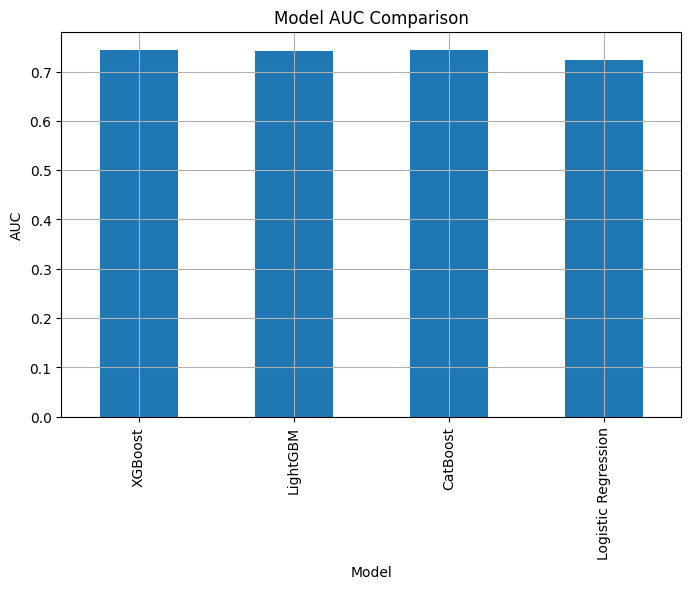

In [11]:


auc_xgb = roc_auc_score(y_all_train, oof_xgb)
auc_lgb = roc_auc_score(y_all_train, oof_lgb)
auc_cat = roc_auc_score(y_all_train, oof_cat)
auc_lr  = auc_lr  # 上面得到的均值

import pandas as pd

df_compare = pd.DataFrame({
    "Model": ["XGBoost", "LightGBM", "CatBoost", "Logistic Regression"],
    "AUC":   [auc_xgb, auc_lgb, auc_cat, auc_lr]
})

print("\n====== 模型表现比较 ======")
print(df_compare)

df_compare.plot(kind='bar', x='Model', y='AUC', legend=False, figsize=(8,5), grid=True)
plt.title("Model AUC Comparison")
plt.ylabel("AUC")
plt.show()

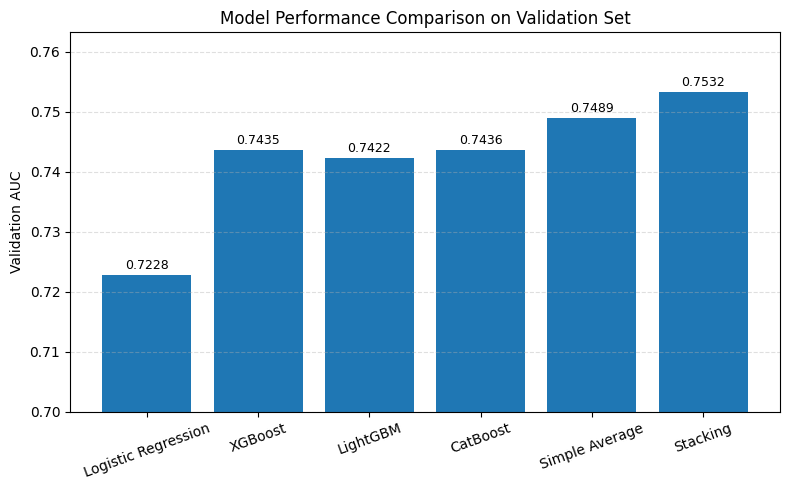

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

auc_lr = 0.722757
auc_xgb = 0.743524
auc_lgb = 0.742242
auc_cat = 0.743573
auc_simple = 0.748920   # 按你表格里的数填
auc_stacking = 0.753210

# 把你已经算好的 AUC 填进来
data = {
    "Model": [
        "Logistic Regression",
        "XGBoost",
        "LightGBM",
        "CatBoost",
        "Simple Average",
        "Stacking"
    ],
    "AUC": [
        auc_lr,
        auc_xgb,
        auc_lgb,
        auc_cat,
        auc_simple,
        auc_stacking
    ]
}

df_auc = pd.DataFrame(data)

plt.figure(figsize=(8, 5))
bars = plt.bar(df_auc["Model"], df_auc["AUC"])

# 在柱子上标数字
for bar, value in zip(bars, df_auc["AUC"]):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.0005,
        f"{value:.4f}",
        ha="center",
        va="bottom",
        fontsize=9,
        rotation=0
    )

plt.ylabel("Validation AUC")
plt.title("Model Performance Comparison on Validation Set")
plt.xticks(rotation=20)
plt.ylim(0.70, max(df_auc["AUC"]) + 0.01)  # 视情况调整下界
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.savefig("model_auc_compare.png", dpi=300, bbox_inches="tight")
plt.show()
